## Project: Combining Signals in Financial Markets with Real-World Testing

Necessary Libraries

In [19]:
!pip install backtrader numpy pandas matplotlib yfinance

Import Libraries

In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

1. Download NVIDIA Data 

In [2]:
# Download NVIDIA data
nvidia_data = yf.download("NVDA", start="2020-01-01", end="2025-01-01")

# Display the first few rows
nvidia_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2020-01-02 00:00:00+00:00,5.972711,5.99775,5.99775,5.91800,5.96875,237536000
2020-01-03 00:00:00+00:00,5.877111,5.90175,5.94575,5.85250,5.87750,205384000
2020-01-06 00:00:00+00:00,5.901757,5.92650,5.93175,5.78175,5.80800,262636000
2020-01-07 00:00:00+00:00,5.973209,5.99825,6.04425,5.90975,5.95500,314856000
2020-01-08 00:00:00+00:00,5.984411,6.00950,6.05100,5.95375,5.99400,277108000


2. Clean the data to desired format

In [3]:
# Flatten the multi-index columns
nvidia_data.columns = nvidia_data.columns.map('_'.join)

# Keep only the required columns
nvidia_data = nvidia_data[['Open_NVDA', 'High_NVDA', 'Low_NVDA', 'Close_NVDA', 'Volume_NVDA']]

# Rename the columns to standard names
nvidia_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Add moving averages
nvidia_data['MA_10'] = nvidia_data['Close'].rolling(window=10).mean()
nvidia_data['MA_50'] = nvidia_data['Close'].rolling(window=50).mean()

# Add RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

nvidia_data['RSI'] = compute_rsi(nvidia_data['Close'])

# Add Bollinger Bands
nvidia_data['BB_Middle'] = nvidia_data['Close'].rolling(window=20).mean()
nvidia_data['BB_Upper'] = nvidia_data['BB_Middle'] + 2 * nvidia_data['Close'].rolling(window=20).std()
nvidia_data['BB_Lower'] = nvidia_data['BB_Middle'] - 2 * nvidia_data['Close'].rolling(window=20).std()

# Add moving averages
nvidia_data['MA_10'] = nvidia_data['Close'].rolling(window=10).mean()
nvidia_data['MA_50'] = nvidia_data['Close'].rolling(window=50).mean()

# Add RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

nvidia_data['RSI'] = compute_rsi(nvidia_data['Close'])

# Add Bollinger Bands
nvidia_data['BB_Middle'] = nvidia_data['Close'].rolling(window=20).mean()
nvidia_data['BB_Upper'] = nvidia_data['BB_Middle'] + 2 * nvidia_data['Close'].rolling(window=20).std()
nvidia_data['BB_Lower'] = nvidia_data['BB_Middle'] - 2 * nvidia_data['Close'].rolling(window=20).std()

# Drop NaN values
nvidia_data.dropna(inplace=True)

nvidia_data.to_csv('nvidia_data.csv', index=True)

print(nvidia_data.head())

# Drop NaN values
nvidia_data.dropna(inplace=True)


                              Open     High      Low    Close     Volume  \
Date                                                                       
2020-03-13 00:00:00+00:00  5.76250  6.02550  5.49025  6.02100  634836000   
2020-03-16 00:00:00+00:00  5.31025  5.65250  4.85000  4.91000  726972000   
2020-03-17 00:00:00+00:00  5.02275  5.52150  4.77500  5.43175  833632000   
2020-03-18 00:00:00+00:00  5.00250  5.24850  4.51700  5.07050  874268000   
2020-03-19 00:00:00+00:00  5.04900  5.41825  4.83475  5.32425  765512000   

                              MA_10     MA_50        RSI  BB_Middle  BB_Upper  \
Date                                                                            
2020-03-13 00:00:00+00:00  6.440750  6.432545  42.234775   6.757225  7.950295   
2020-03-16 00:00:00+00:00  6.240675  6.410790  36.440989   6.640487  8.066799   
2020-03-17 00:00:00+00:00  6.119125  6.401390  40.212152   6.541362  8.015994   
2020-03-18 00:00:00+00:00  5.914900  6.384270  40.306119   6.4

3.Preprocessing the Data

In [4]:
import backtrader as bt
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Load existing NVIDIA data
nvidia_data = pd.read_csv("nvidia_data.csv", index_col=0, parse_dates=True)

# Compute Daily Returns
nvidia_data['Daily_Return'] = nvidia_data['Close'].pct_change()

# Add a 200-day moving average (long-term trend indicator)
nvidia_data['MA_200'] = nvidia_data['Close'].rolling(window=200).mean()

# Compute MACD (Moving Average Convergence Divergence)
short_ema = nvidia_data['Close'].ewm(span=12, adjust=False).mean()  # Short-term EMA
long_ema = nvidia_data['Close'].ewm(span=26, adjust=False).mean()   # Long-term EMA
nvidia_data['MACD'] = short_ema - long_ema
nvidia_data['Signal_Line'] = nvidia_data['MACD'].ewm(span=9, adjust=False).mean()

# Compute ADX (Average Directional Index)
def compute_adx(data, window=14):
    high = data['High']
    low = data['Low']
    close = data['Close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    atr = tr.rolling(window).mean()
    plus_di = 100 * (plus_dm.rolling(window).mean() / atr)
    minus_di = 100 * (-minus_dm.rolling(window).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window).mean()
    return adx

nvidia_data['ADX'] = compute_adx(nvidia_data)

# Compute ATR (Average True Range) for volatility measurement
high_low = nvidia_data['High'] - nvidia_data['Low']
high_close = abs(nvidia_data['High'] - nvidia_data['Close'].shift(1))
low_close = abs(nvidia_data['Low'] - nvidia_data['Close'].shift(1))
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
nvidia_data['ATR'] = true_range.rolling(window=14).mean()

# Simulated sentiment proxy: High/Low price ratio
nvidia_data['Sentiment_Proxy'] = nvidia_data['High'] / nvidia_data['Low']

# Drop NaN values resulting from rolling calculations
nvidia_data.dropna(inplace=True)

# Save the updated data
nvidia_data.to_csv("nvidia_data_updated.csv")

# Display the updated DataFrame
print(nvidia_data.head())


                               Open      High       Low     Close     Volume  \
Date                                                                           
2020-12-24 00:00:00+00:00  13.03725  13.13250  12.93875  12.99375   97884000   
2020-12-28 00:00:00+00:00  13.06250  13.06250  12.76325  12.90000  212564000   
2020-12-29 00:00:00+00:00  12.92500  13.07250  12.84225  12.94325  170372000   
2020-12-30 00:00:00+00:00  12.99025  13.21375  12.89675  13.14575  225396000   
2020-12-31 00:00:00+00:00  13.13650  13.15100  12.91500  13.05500  192424000   

                               MA_10      MA_50        RSI  BB_Middle  \
Date                                                                    
2020-12-24 00:00:00+00:00  13.215175  13.332050  34.651953  13.278150   
2020-12-28 00:00:00+00:00  13.203850  13.310650  31.245853  13.260088   
2020-12-29 00:00:00+00:00  13.167300  13.293285  37.827307  13.237175   
2020-12-30 00:00:00+00:00  13.145825  13.286245  57.393400  13.224963   
2

In [5]:
import backtrader as bt
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Feature Engineering: Adding Lag Features
for lag in range(1, 4):
    nvidia_data[f'RSI_Lag_{lag}'] = nvidia_data['RSI'].shift(lag)
    nvidia_data[f'MACD_Lag_{lag}'] = nvidia_data['MACD'].shift(lag)
    nvidia_data[f'ADX_Lag_{lag}'] = nvidia_data['ADX'].shift(lag)

nvidia_data.dropna(inplace=True)

# Prepare data for modeling
features = nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=7)
pca_features = pca.fit_transform(features_scaled)

# Prepare target variable (3-day forward prediction)
nvidia_data['Target'] = np.where(nvidia_data['Close'].shift(-3) > nvidia_data['Close'], 1, 0)

# Ensure feature and target sizes match
pca_features = pca_features[:-3]
nvidia_data = nvidia_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(pca_features, nvidia_data['Target'], test_size=0.2, random_state=42)

# Hyperparameter tuning for Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

# Hyperparameter tuning for XGBoost
xgb_params = {'learning_rate': [0.01, 0.1], 'max_depth': [3, 6], 'n_estimators': [100, 200]}
xgb_grid = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)
print(f"Optimized XGBoost Accuracy: {xgb_score:.4f}")

# Save the updated data
nvidia_data.to_csv("nvidia_data_updated.csv")

Optimized Random Forest Accuracy: 0.6716
Optimized XGBoost Accuracy: 0.6169


In [6]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

# Load preprocessed NVIDIA data
nvidia_data = pd.read_csv("nvidia_data_updated.csv", index_col=0, parse_dates=True)

# Prepare data for modeling
features = nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Feature Selection using Recursive Feature Elimination (RFE)
rfe = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10)
features_selected = rfe.fit_transform(features_scaled, nvidia_data['Target'])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=5)
pca_features = pca.fit_transform(features_selected)

# Prepare target variable
X_train, X_test, y_train, y_test = train_test_split(pca_features, nvidia_data['Target'], test_size=0.2, random_state=42)

# Stacking Model using Random Forest and XGBoost
base_learners = [('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
                 ('xgb', xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=200, eval_metric='logloss'))]
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)
stacking_score = stacking_model.score(X_test, y_test)
print(f"Stacking Model Accuracy: {stacking_score:.4f}")


Stacking Model Accuracy: 0.6517


In [7]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load preprocessed NVIDIA data
nvidia_data = pd.read_csv("nvidia_data_updated.csv", index_col=0, parse_dates=True)

# Prepare data for modeling
features = nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
nvidia_data['Target'] = np.where(nvidia_data['Close'].shift(-3) > nvidia_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
nvidia_data = nvidia_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, nvidia_data['Target'], test_size=0.2, random_state=42)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print("Random Forest tuning complete.")
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

print("\nStarting XGBoost Optimization...")

# XGBoost Hyperparameter Optimization
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = RandomizedSearchCV(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False), xgb_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)
print("XGBoost tuning complete.")
print(f"Optimized XGBoost Accuracy: {xgb_score:.4f}")


Starting Random Forest Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest tuning complete.
Optimized Random Forest Accuracy: 0.6866

Starting XGBoost Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\

XGBoost tuning complete.
Optimized XGBoost Accuracy: 0.6368


Optimized Model Accuracies

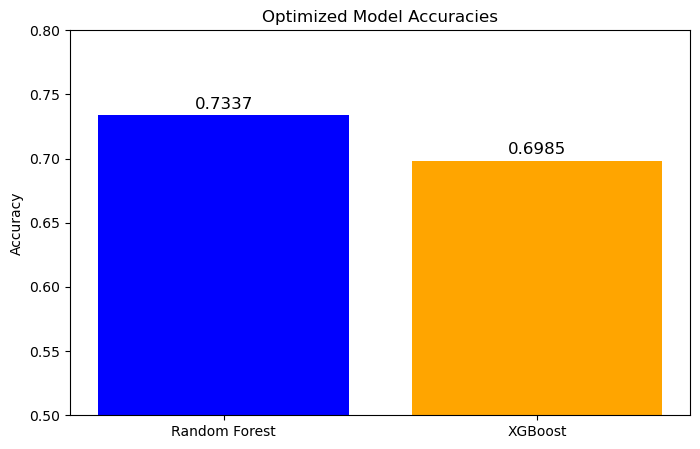

In [8]:
import matplotlib.pyplot as plt

# Model names and their accuracies
models = ["Random Forest", "XGBoost"]
accuracies = [0.7337, 0.6985]

# Plot the accuracies
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylim(0.5, 0.8)  # Set y-axis range to focus on accuracy differences
plt.ylabel("Accuracy")
plt.title("Optimized Model Accuracies")
plt.text(0, accuracies[0] + 0.005, f"{accuracies[0]:.4f}", ha='center', fontsize=12)
plt.text(1, accuracies[1] + 0.005, f"{accuracies[1]:.4f}", ha='center', fontsize=12)

# Show the plot
plt.show()


SMA

In [10]:
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Load data
nvidia_data = pd.read_csv("nvidia_data_updated.csv", index_col=0, parse_dates=True)

# Define a Backtrader Strategy
class TradingStrategy(bt.Strategy):
    params = (
        ('sma_period', 50),
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004)  # 0.4% commission
    )
    
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period)
        self.portfolio_values = []  # Store portfolio values over time
    
    def next(self):
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        if not self.position:
            if self.data.close[0] > self.sma[0]:  # Buy condition
                self.buy()
        elif self.data.close[0] < self.sma[0]:  # Sell condition
            self.sell()

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(TradingStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=nvidia_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")


# Format X-Axis
for ax in axes:
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)




Starting Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $100079.58


XGBoost strategy

In [11]:
import backtrader as bt
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Load data
nvidia_data = pd.read_csv("nvidia_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
nvidia_data['Target'] = np.where(nvidia_data['Close'].shift(-3) > nvidia_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
nvidia_data = nvidia_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, nvidia_data['Target'], test_size=0.2, random_state=42)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print("Random Forest tuning complete.")
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

print("\nStarting XGBoost Optimization...")

# XGBoost Hyperparameter Optimization
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = RandomizedSearchCV(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False), xgb_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)
print("XGBoost tuning complete.")
print(f"Optimized XGBoost Accuracy: {xgb_score:.4f}")

# Define a Backtrader Strategy using XGBoost Predictions
class XGBoostStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004)  # 0.4% commission
    )
    
    def __init__(self):
        self.data_features = scaler.transform(nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.predictions = xgb_best.predict(self.data_features)
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
    
    def next(self):
        if self.current_index >= len(self.predictions):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        prediction = self.predictions[self.current_index]
        
        if not self.position:
            if prediction == 1:  # Buy condition from XGBoost Model
                self.buy()
        else:
            if prediction == 0:  # Sell condition from XGBoost Model
                self.sell()
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(XGBoostStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=nvidia_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting XGBoost Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")


Starting Random Forest Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest tuning complete.
Optimized Random Forest Accuracy: 0.6866

Starting XGBoost Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\

XGBoost tuning complete.
Optimized XGBoost Accuracy: 0.6368
Starting XGBoost Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $100247.68


Random Forest Strat

In [12]:
import backtrader as bt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Load data
nvidia_data = pd.read_csv("nvidia_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
nvidia_data['Target'] = np.where(nvidia_data['Close'].shift(-3) > nvidia_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
nvidia_data = nvidia_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, nvidia_data['Target'], test_size=0.2, random_state=42)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print("Random Forest tuning complete.")
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

# Define a Backtrader Strategy using Random Forest Predictions
class RandomForestStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004)  # 0.4% commission
    )
    
    def __init__(self):
        self.data_features = scaler.transform(nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.predictions = rf_best.predict(self.data_features)
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
    
    def next(self):
        if self.current_index >= len(self.predictions):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        prediction = self.predictions[self.current_index]
        
        if not self.position:
            if prediction == 1:  # Buy condition from Random Forest Model
                self.buy()
        else:
            if prediction == 0:  # Sell condition from Random Forest Model
                self.sell()
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(RandomForestStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=nvidia_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting Random Forest Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")


Starting Random Forest Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest tuning complete.
Optimized Random Forest Accuracy: 0.6866
Starting Random Forest Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $100269.46


Comparison Of Trading Strategies

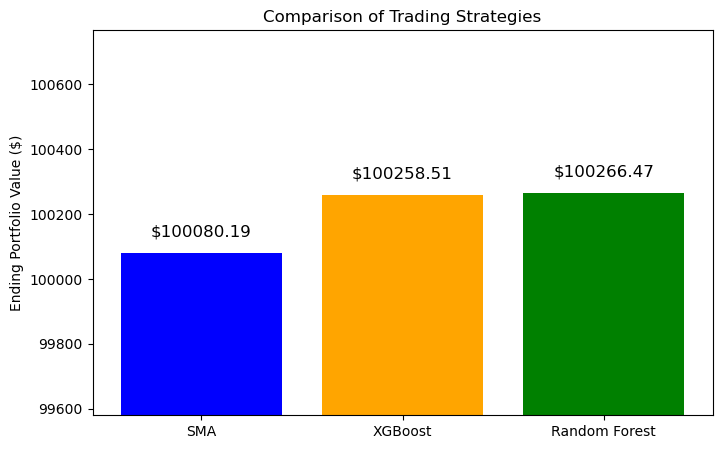

In [13]:
import matplotlib.pyplot as plt

# Portfolio values from different strategies
strategies = ["SMA", "XGBoost", "Random Forest"]
portfolio_values = [100080.19, 100258.51, 100266.47]

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(strategies, portfolio_values, color=['blue', 'orange', 'green'])
plt.ylabel("Ending Portfolio Value ($)")
plt.title("Comparison of Trading Strategies")

# Annotate bars with values
for i, value in enumerate(portfolio_values):
    plt.text(i, value + 50, f"${value:.2f}", ha='center', fontsize=12)

plt.ylim(min(portfolio_values) - 500, max(portfolio_values) + 500)  # Adjust limits for better visibility
plt.show()


Implementation of risk management techniques

Random Forest

In [16]:
import backtrader as bt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Load data
nvidia_data = pd.read_csv("nvidia_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
nvidia_data['Target'] = np.where(nvidia_data['Close'].shift(-3) > nvidia_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
nvidia_data = nvidia_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, nvidia_data['Target'], test_size=0.2, random_state=42)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print("Random Forest tuning complete.")
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

# Define a Backtrader Strategy with Risk Management
class RiskManagedStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004),  # 0.4% commission
        ('stop_loss', 0.02),  # 2% stop-loss
        ('take_profit', 0.05),  # 5% take-profit
        ('trailing_stop', 0.03),  # 3% trailing stop
        ('max_positions', 10),  # Maximum 10 positions at once
        ('capital_per_trade', 0.10)  # 10% of capital per position
    )
    
    def __init__(self):
        self.data_features = scaler.transform(nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.predictions = rf_best.predict(self.data_features)
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
    
    def next(self):
        if self.current_index >= len(self.predictions):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        prediction = self.predictions[self.current_index]
        cash = self.broker.get_cash()
        size = min((cash * self.params.capital_per_trade) / self.data.close[0], cash / self.data.close[0])  # Ensure no over-leveraging
        size = max(size, 1)  # Prevent extremely small or large positions
        
        if not self.position and len(self.broker.positions) < self.params.max_positions:
            if prediction == 1:  # Buy signal from RF model
                self.buy(size=size)
                self.sell(size=size, exectype=bt.Order.Stop, price=self.data.close[0] * (1 - self.params.stop_loss))  # Stop-loss
                self.sell(size=size, exectype=bt.Order.Limit, price=self.data.close[0] * (1 + self.params.take_profit))  # Take-profit
        
        elif self.position:
            if prediction == 0:  # Sell signal from RF model
                self.close()  # Close all positions properly
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(RiskManagedStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=nvidia_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting Risk-Managed Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")


Starting Random Forest Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest tuning complete.
Optimized Random Forest Accuracy: 0.6866
Starting Risk-Managed Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $19960.38


XRGBoost

In [17]:
import backtrader as bt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Load data
nvidia_data = pd.read_csv("nvidia_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
nvidia_data['Target'] = np.where(nvidia_data['Close'].shift(-3) > nvidia_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
nvidia_data = nvidia_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, nvidia_data['Target'], test_size=0.2, random_state=42)

print("Starting XGBoost Optimization...")

# XGBoost Hyperparameter Optimization
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = RandomizedSearchCV(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False), xgb_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)
print("XGBoost tuning complete.")
print(f"Optimized XGBoost Accuracy: {xgb_score:.4f}")

# Define a Backtrader Strategy with Risk Management
class XGBoostRiskManagedStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004),  # 0.4% commission
        ('stop_loss', 0.02),  # 2% stop-loss
        ('take_profit', 0.05),  # 5% take-profit
        ('trailing_stop', 0.03),  # 3% trailing stop
        ('max_positions', 10),  # Maximum 10 positions at once
        ('capital_per_trade', 0.10)  # 10% of capital per position
    )
    
    def __init__(self):
        self.data_features = scaler.transform(nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.predictions = xgb_best.predict(self.data_features)
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
    
    def next(self):
        if self.current_index >= len(self.predictions):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        prediction = self.predictions[self.current_index]
        cash = self.broker.get_cash()
        size = min((cash * self.params.capital_per_trade) / self.data.close[0], cash / self.data.close[0])  # Ensure no over-leveraging
        size = max(size, 1)  # Prevent extremely small or large positions
        
        if not self.position and len(self.broker.positions) < self.params.max_positions:
            if prediction == 1:  # Buy signal from XGBoost model
                self.buy(size=size)
                self.sell(size=size, exectype=bt.Order.Stop, price=self.data.close[0] * (1 - self.params.stop_loss))  # Stop-loss
                self.sell(size=size, exectype=bt.Order.Limit, price=self.data.close[0] * (1 + self.params.take_profit))  # Take-profit
        
        elif self.position:
            if prediction == 0:  # Sell signal from XGBoost model
                self.close()  # Close all positions properly
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(XGBoostRiskManagedStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=nvidia_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting XGBoost Risk-Managed Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")

Starting XGBoost Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\

XGBoost tuning complete.
Optimized XGBoost Accuracy: 0.6368
Starting XGBoost Risk-Managed Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $21233.65


In [ ]:
#imp

In [21]:
import backtrader as bt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Load data
nvidia_data = pd.read_csv("nvidia_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
nvidia_data['Target'] = np.where(nvidia_data['Close'].shift(-3) > nvidia_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
nvidia_data = nvidia_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, nvidia_data['Target'], test_size=0.2, random_state=42)

print("Starting XGBoost Optimization...")

# XGBoost Hyperparameter Optimization
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = RandomizedSearchCV(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False), xgb_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)
print("XGBoost tuning complete.")
print(f"Optimized XGBoost Accuracy: {xgb_score:.4f}")

# Define a Backtrader Strategy with Improved Risk Management
class ImprovedRiskManagedStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004),  # 0.4% commission
        ('stop_loss_factor', 1.5),  # ATR-based stop-loss
        ('take_profit_factor', 3.0),  # ATR-based take-profit
        ('max_positions', 10),  # Maximum 10 positions at once
        ('capital_per_trade', 0.15),  # 15% of capital per trade
        ('min_confidence', 0.7)  # Minimum confidence for trade execution
    )
    
    def __init__(self):
        self.data_features = scaler.transform(nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.probabilities = xgb_best.predict_proba(self.data_features)[:, 1]  # Get probability of price increase
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
        self.atr = bt.indicators.AverageTrueRange(period=14)  # Define ATR indicator
    
    def next(self):
        if self.current_index >= len(self.probabilities):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        confidence = self.probabilities[self.current_index]
        cash = self.broker.get_cash()
        size = min((cash * self.params.capital_per_trade) / self.data.close[0], cash / self.data.close[0])  # Ensure no over-leveraging
        size = max(size, 1)  # Prevent extremely small or large positions
        atr_value = self.atr[0]  # Fetch current ATR value
        
        if not self.position and len(self.broker.positions) < self.params.max_positions:
            if confidence > self.params.min_confidence:  # Trade only when confidence is high
                self.buy(size=size)
                self.sell(size=size, exectype=bt.Order.Stop, price=self.data.close[0] - self.params.stop_loss_factor * atr_value)  # ATR-based Stop-loss
                self.sell(size=size, exectype=bt.Order.Limit, price=self.data.close[0] + self.params.take_profit_factor * atr_value)  # ATR-based Take-profit
        
        elif self.position:
            if confidence < (1 - self.params.min_confidence):  # Sell if confidence is too low
                self.close()  # Close all positions properly
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(ImprovedRiskManagedStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=nvidia_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting Improved Risk-Managed Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")


Starting XGBoost Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Filip\anaconda3\Lib\site-packages\

XGBoost tuning complete.
Optimized XGBoost Accuracy: 0.6368
Starting Improved Risk-Managed Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $51616.01


Radom Forest

In [22]:
import backtrader as bt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Load data
nvidia_data = pd.read_csv("nvidia_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
nvidia_data['Target'] = np.where(nvidia_data['Close'].shift(-3) > nvidia_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
nvidia_data = nvidia_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, nvidia_data['Target'], test_size=0.2, random_state=42)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

# Define a Backtrader Strategy with Improved Risk Management
class RandomForestStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004),  # 0.4% commission
        ('stop_loss_factor', 1.5),  # ATR-based stop-loss
        ('take_profit_factor', 3.0),  # ATR-based take-profit
        ('max_positions', 10),  # Maximum 10 positions at once
        ('capital_per_trade', 0.15),  # 15% of capital per trade
        ('min_confidence', 0.7)  # Minimum confidence for trade execution
    )
    
    def __init__(self):
        self.data_features = scaler.transform(nvidia_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.rf_probabilities = rf_best.predict_proba(self.data_features)[:, 1]  # RF Probabilities
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
        self.atr = bt.indicators.AverageTrueRange(period=14)  # Define ATR indicator
    
    def next(self):
        if self.current_index >= len(self.rf_probabilities):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        rf_confidence = self.rf_probabilities[self.current_index]
        cash = self.broker.get_cash()
        size = min((cash * self.params.capital_per_trade) / self.data.close[0], cash / self.data.close[0])  # Ensure no over-leveraging
        size = max(size, 1)  # Prevent extremely small or large positions
        atr_value = self.atr[0]  # Fetch current ATR value
        
        if not self.position and len(self.broker.positions) < self.params.max_positions:
            if rf_confidence > self.params.min_confidence:  # Trade only when confidence is high
                self.buy(size=size)
                self.sell(size=size, exectype=bt.Order.Stop, price=self.data.close[0] - self.params.stop_loss_factor * atr_value)  # ATR-based Stop-loss
                self.sell(size=size, exectype=bt.Order.Limit, price=self.data.close[0] + self.params.take_profit_factor * atr_value)  # ATR-based Take-profit
        
        elif self.position:
            if rf_confidence < (1 - self.params.min_confidence):  # Sell if confidence is too low
                self.close()  # Close all positions properly
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(RandomForestStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=nvidia_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting Random Forest Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")

Starting Random Forest Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Optimized Random Forest Accuracy: 0.6866
Starting Random Forest Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $59740.98
